In [1]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()
from cycler import cycler
import matplotlib.patches as mpatches
import seaborn as sns
import arviz as az
import scipy.stats as stats
import ROOT as r
import time
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=22
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')
%jsroot on

Welcome to JupyROOT 6.26/00


In [2]:
def fit(nsamples,nbins,start): #define starting index
    cols=[f'toybin{i:04d}' for i in range(start,start+nbins)]
    diagnostics_df=pd.DataFrame(columns=cols,index=['sigma_median','mcse','rhat'])
    sigma_df=pd.DataFrame(columns=cols)
    sigma_2pi0_df=pd.DataFrame(columns=cols)
    for i in range(start,start+nbins):#no. of toy bins
        print(f"Fitting toy MC bin no.{i}")
        #read data
        df=pd.read_csv(f"toybins/toybin{i:04d}.txt",sep="\t")
        df_2pi0=pd.read_csv(f"toybins/2pi0bin.txt",sep='\t')
        #df=pd.read_csv(f"new_toy_MC.txt",sep="\t")
        df.columns=['pol','phi','weight']
        df_2pi0.columns=['sigma','dsigma','f_s','f_b']
        #these are prompt peak events
        prmpt=df.loc[df['weight']==1]
        prmpt=prmpt.reset_index(drop=True)
        #sideband
        side=df.loc[df['weight']!=1]
        side=side.reset_index(drop=True)
        nprmpt=len(prmpt)
        total_nside=(len(side))
        #weights used in the data, including 1--> exterminate 1
        weights=pd.unique(df['weight'].values)
        weights=np.array(weights[weights!=1])
        #sideband events are identified by the corresponding weights
        nside=np.array([len(df.loc[df['weight']==weights[i]])for i in range(len(weights))])
        #fraction of signal in prompt peak, note that the weights are already negative (TO BE CHECKED W/ FARAHS DATA!)
        f=(nprmpt+np.sum(nside*weights))/nprmpt
        print(f)
        stan_data={
            'N':nprmpt, #no. of prompt peak events and corresponding pol and phi values
            'phi_prmpt':list(prmpt['phi'].values),
            'pol_prmpt':list(prmpt['pol'].values),
            'M':total_nside,#no. of sideband events and..
            'phi_side':list(side['phi'].values),
            'pol_side':list(side['pol'].values),
            'f':f, #fraction of signal in prmpt peak
            'f_s': df_2pi0['f_s'].values[0], #fraction of etap events
            'f_b': df_2pi0['f_b'].values[0], #fraction of 2pi0 events
            'sigma_2pi0_meas': df_2pi0['sigma'].values[0],#measured value of sigma_2pi0 
            'dsigma_2pi0_meas': df_2pi0['dsigma'].values[0] #w/ stat error
        }
        print(nprmpt, total_nside)
        #now the stan model and mcmc
        model=sp.CmdStanModel(stan_file='toyMC_stan.stan')
        model.compile()
        fitobj=model.sample(data=stan_data,iter_sampling=nsamples,inits=0,output_dir='./stan_trash',show_progress=True)
        summary=fitobj.summary()
        samples=fitobj.draws_pd()
        #get mcmc diagnostics
        median=summary['50%']['sigma']
        mcse=(az.mcse(np.transpose(fitobj.draws(concat_chains=False)[:,:,7]),method='median'))
        rhat=az.rhat(np.transpose(fitobj.draws(concat_chains=False)[:,:,7]))
        tmp_list=[median,mcse,rhat]
        currbin=f"toybin{i:04d}"
        diagnostics_df[currbin]=tmp_list
        sigma_df[currbin]=samples['sigma']
        sigma_2pi0_df[currbin]=samples['sigma_2pi0']
    return diagnostics_df, sigma_df, sigma_2pi0_df, summary

def fit_bin(nsamples,binnr): #fit only one bin
    #read data
    df=pd.read_csv(f"toybins/toybin{binnr:04d}.txt",sep="\t")
    df.columns=['pol','phi','weight']
    df_2pi0=pd.read_csv(f"toybins/2pi0bin.txt",sep='\t')
    df_2pi0.columns=['sigma','dsigma','f_s','f_b']


    #these are prompt peak events
    prmpt=df.loc[df['weight']==1]
    prmpt=prmpt.reset_index(drop=True)
    #sideband
    side=df.loc[df['weight']!=1]
    side=side.reset_index(drop=True)
    nprmpt=len(prmpt)
    total_nside=(len(side))
    #weights used in the data, including 1--> exterminate 1
    weights=pd.unique(df['weight'].values)
    weights=np.array(weights[weights!=1])
    #sideband events are identified by the corresponding weights
    nside=np.array([len(df.loc[df['weight']==weights[i]])for i in range(len(weights))])
    #fraction of signal in prompt peak, note that the weights are already negative (TO BE CHECKED W/ FARAHS DATA!)
    f=(nprmpt+np.sum(nside*weights))/nprmpt
    print(f)
    stan_data={
            'N':nprmpt, #no. of prompt peak events and corresponding pol and phi values
            'phi_prmpt':list(prmpt['phi'].values),
            'pol_prmpt':list(prmpt['pol'].values),
            'M':total_nside,#no. of sideband events and..
            'phi_side':list(side['phi'].values),
            'pol_side':list(side['pol'].values),
            'f':f, #fraction of signal in prmpt peak
            'f_s': df_2pi0['f_s'].values[0], #fraction of etap events
            'f_b': df_2pi0['f_b'].values[0], #fraction of 2pi0 events
            'sigma_2pi0_meas': df_2pi0['sigma'].values[0],#measured value of sigma_2pi0 
            'dsigma_2pi0_meas': df_2pi0['dsigma'].values[0] #w/ stat error
        }
    print(nprmpt, total_nside)
    #now the stan model and mcmc
    model=sp.CmdStanModel(stan_file='toyMC_stan.stan')
    model.compile()
    fitobj=model.sample(data=stan_data,iter_sampling=nsamples,inits=0)
    summary=fitobj.summary()
    samples=fitobj.draws_pd()
    return samples,summary

In [8]:
dfs=fit(nsamples=1000,nbins=1000,start=0)
diagnostics=dfs[0]
sigma=dfs[1]
#diagnostics.to_csv('toy_diagnostics.csv')
#sigma.to_csv('toy_sigma.csv')


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


Fitting toy MC bin no.0
0.9497265625
384 297


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



Fitting toy MC bin no.1
0.9499282296650717
418 322


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing



Fitting toy MC bin no.2
0.9498756218905473
402 310


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing



Fitting toy MC bin no.3
0.9495989304812834
374 290


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing



Fitting toy MC bin no.4
0.9496616541353384
399 309


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling



Fitting toy MC bin no.5
0.9497576530612245
392 303


INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



Fitting toy MC bin no.6
0.9497727272727272
374 289


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



Fitting toy MC bin no.7
0.9496616541353384
399 309


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



Fitting toy MC bin no.8
0.9497265625
384 297


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing



Fitting toy MC bin no.9
0.9498714652956298
389 300


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing



Fitting toy MC bin no.10
0.9498245614035088
399 308


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



Fitting toy MC bin no.11
0.9496291560102302
391 303


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



Fitting toy MC bin no.12
0.9496335078534032
382 296


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



Fitting toy MC bin no.13
0.9497567567567569
370 286


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



Fitting toy MC bin no.14
0.9498815789473684
380 293


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing



Fitting toy MC bin no.15
0.9498891625615763
406 313


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



Fitting toy MC bin no.16
0.9496335078534032
382 296


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing



Fitting toy MC bin no.17
0.9496723300970873
412 319


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



Fitting toy MC bin no.18
0.9498795180722891
415 320


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



Fitting toy MC bin no.19
0.9501608579088473
373 286


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



Fitting toy MC bin no.20
0.9497265625
384 297


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



Fitting toy MC bin no.21
0.9501554404145077
386 296


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



Fitting toy MC bin no.22
0.9500508905852417
393 302


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



Fitting toy MC bin no.23
0.9497727272727272
440 340


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

ERROR:cmdstanpy:Chain [3] error: terminated by signal 2 Unknown error -2
ERROR:cmdstanpy:Chain [2] error: terminated by signal 2 Unknown error -2


KeyboardInterrupt: 

In [5]:
dfs[0]

,toybin0000
sigma_median,0.470000
mcse,0.004726
rhat,1.002393


In [2]:
sigma_df=pd.read_csv('toy_sigma.csv',index_col=0)
sigma_2pi0_df=pd.read_csv('toy_sigma2pi0.csv',index_col=0)
diagnostics_df=pd.read_csv('toy_diagnostics.csv',index_col=0)

In [35]:
for col in sigma_df.columns:
    data = [sigma_df[col].values[i*5000:(i+1)*5000] for i in range(4)]
    rhat = az.rhat(np.array(data))
    diagnostics_df[col]['rhat']=rhat

(4, 5000)

# R hat diagnostics

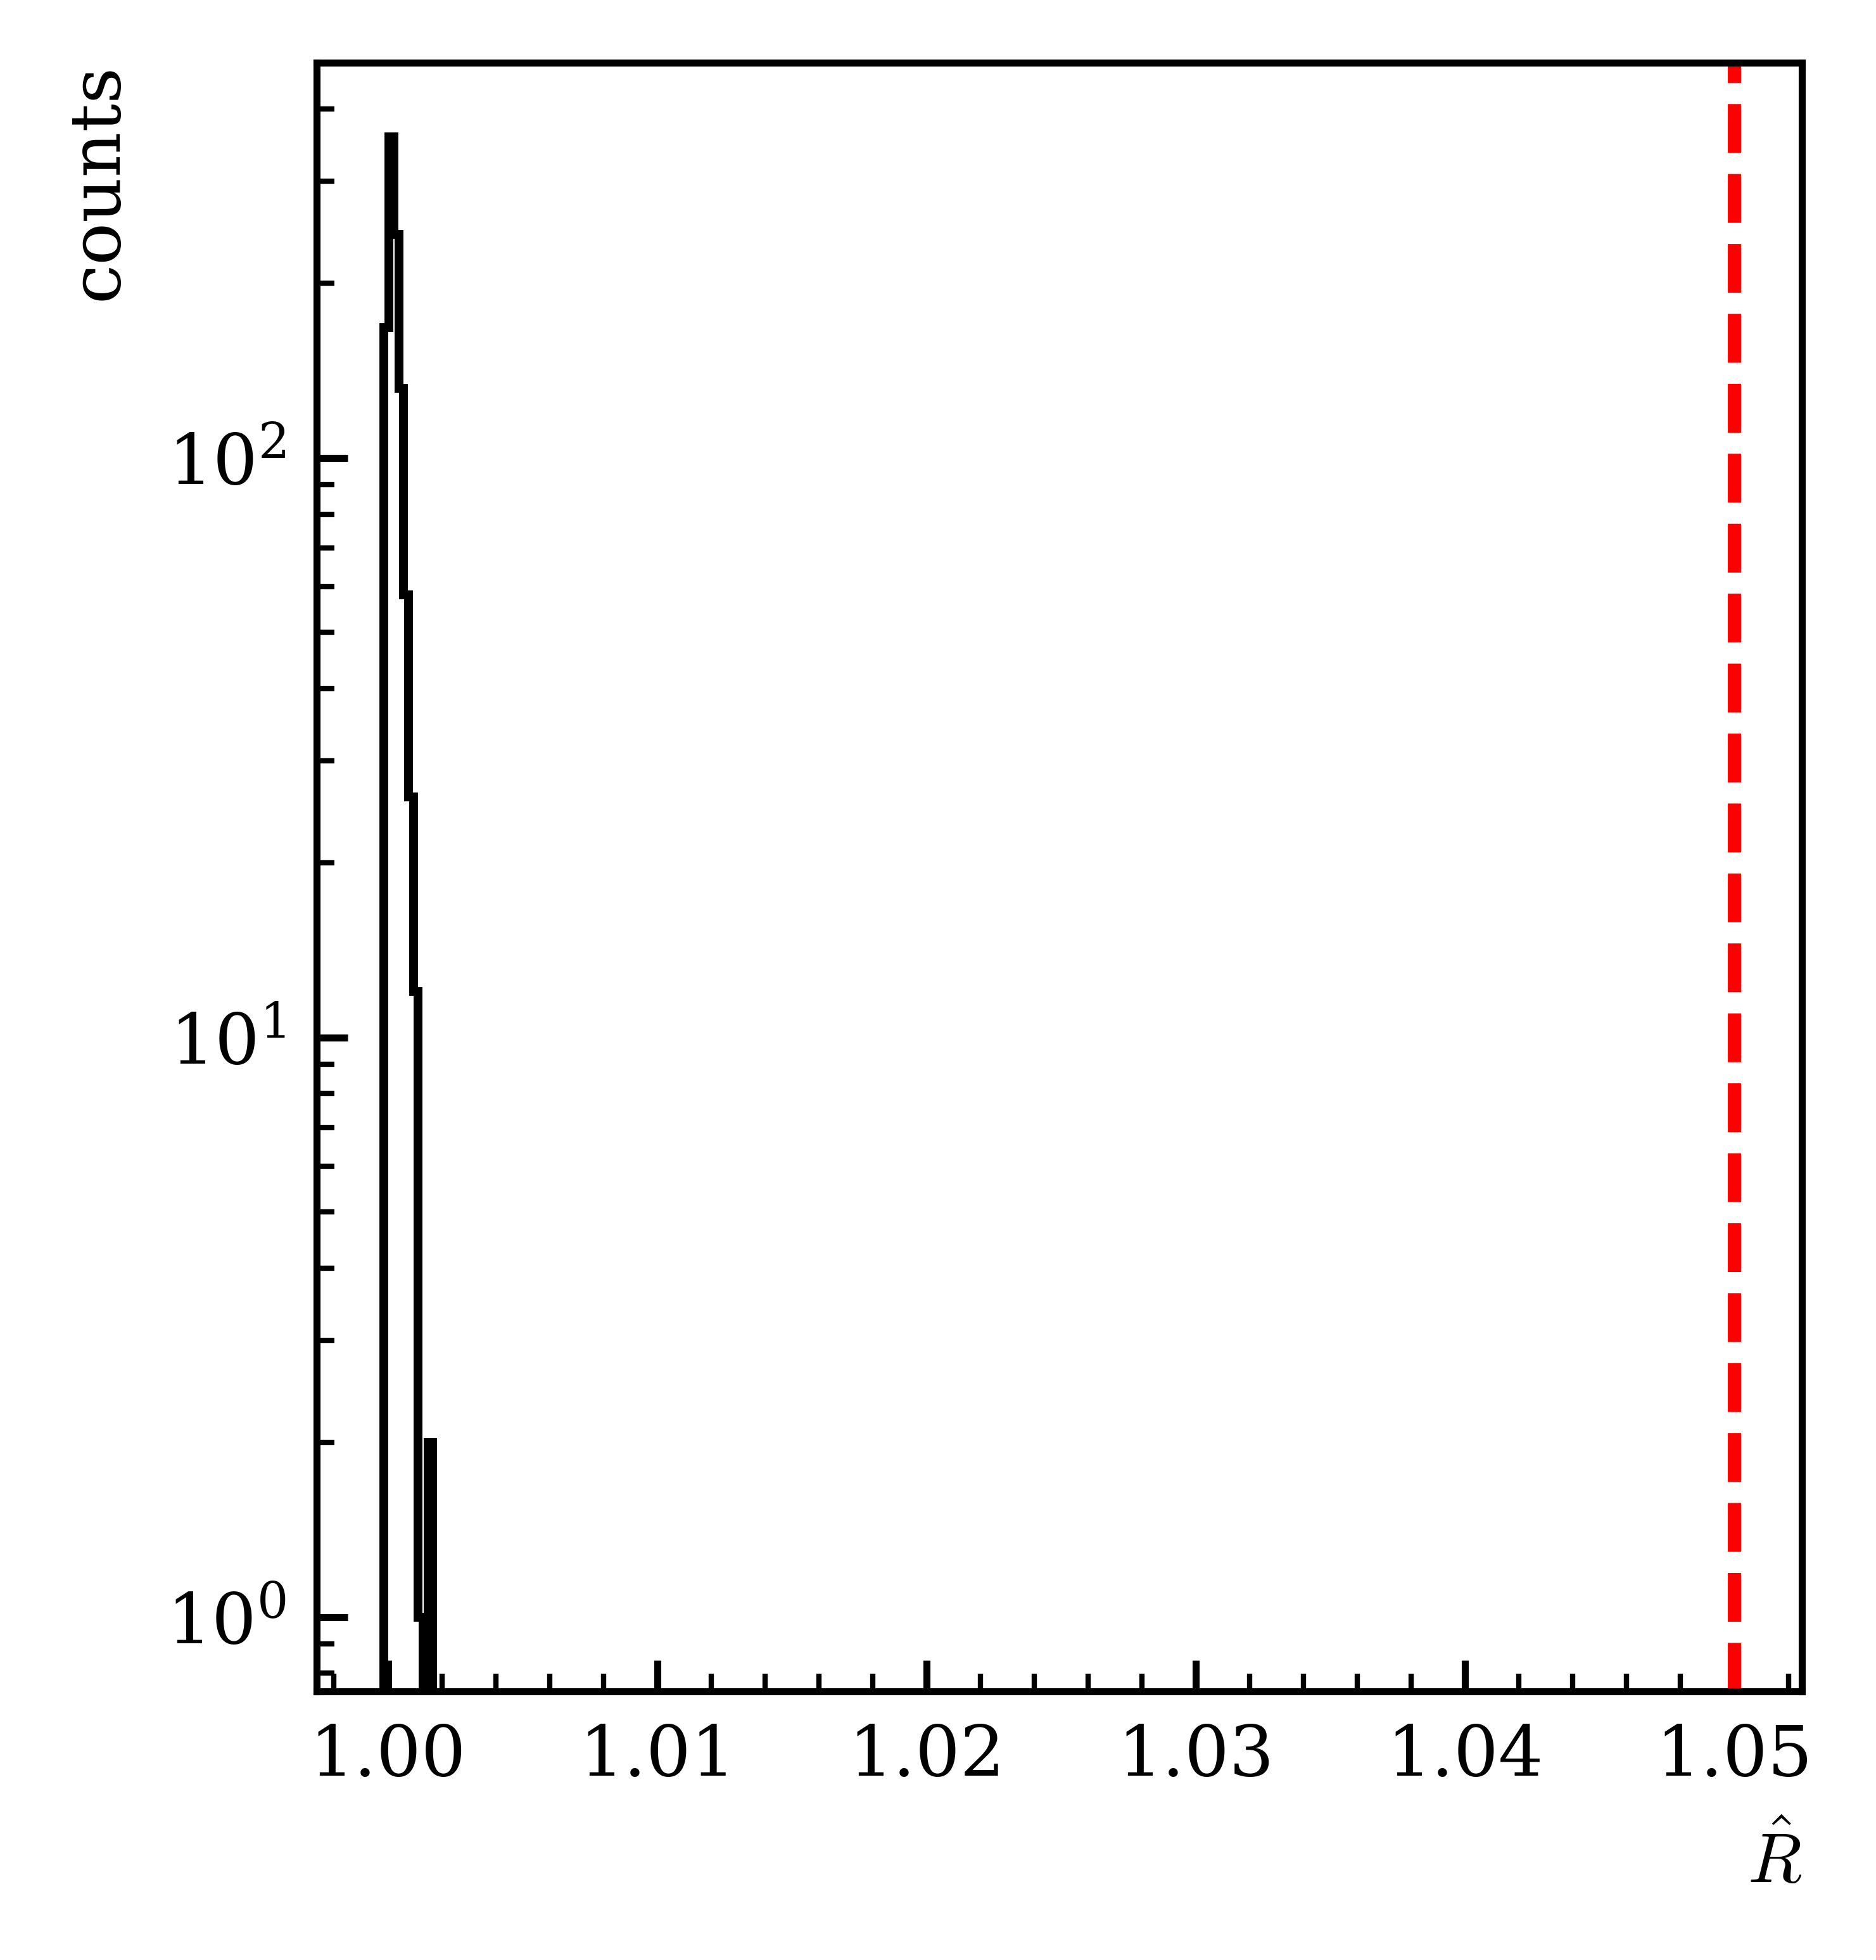

In [36]:
plt.rcParams['font.size']=8
fig, ax = plt.subplots(figsize=([15.3728/2.54/2,8.6472/2.54]),dpi=1000)

ax.hist(diagnostics_df.loc['rhat'].values,histtype='step',log=True)
#ax.set_xlim([0,1])
#plt.hist(np.abs(np.array(diagnostics_df.loc['mcse'].values)),histtype='step',bins=20)
ax.set_xlabel(r'$\hat{R}$',horizontalalignment='right',x=1.0)
#ax.set_xlabel(r'$\sigma_\mathrm{MCSE}/\mathrm{median}[p(\Sigma|y)]$',horizontalalignment='right',x=1.0)
ax.set_ylabel('counts',horizontalalignment='right',y=1.0)
ax.axvline(x=1.05,color='red',linestyle='--')
ax.grid(False)
ax.tick_params(axis='both',which='both',direction='in')

#plt.xscale('log')
#plt.savefig('./plots/toyMC_mcse_hist_raw.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()
fig.savefig('./plots/toyMC_rhat_hist.pdf',format='pdf',dpi=1000,bbox_inches='tight')

# Relative Monte Carlo Standard Error

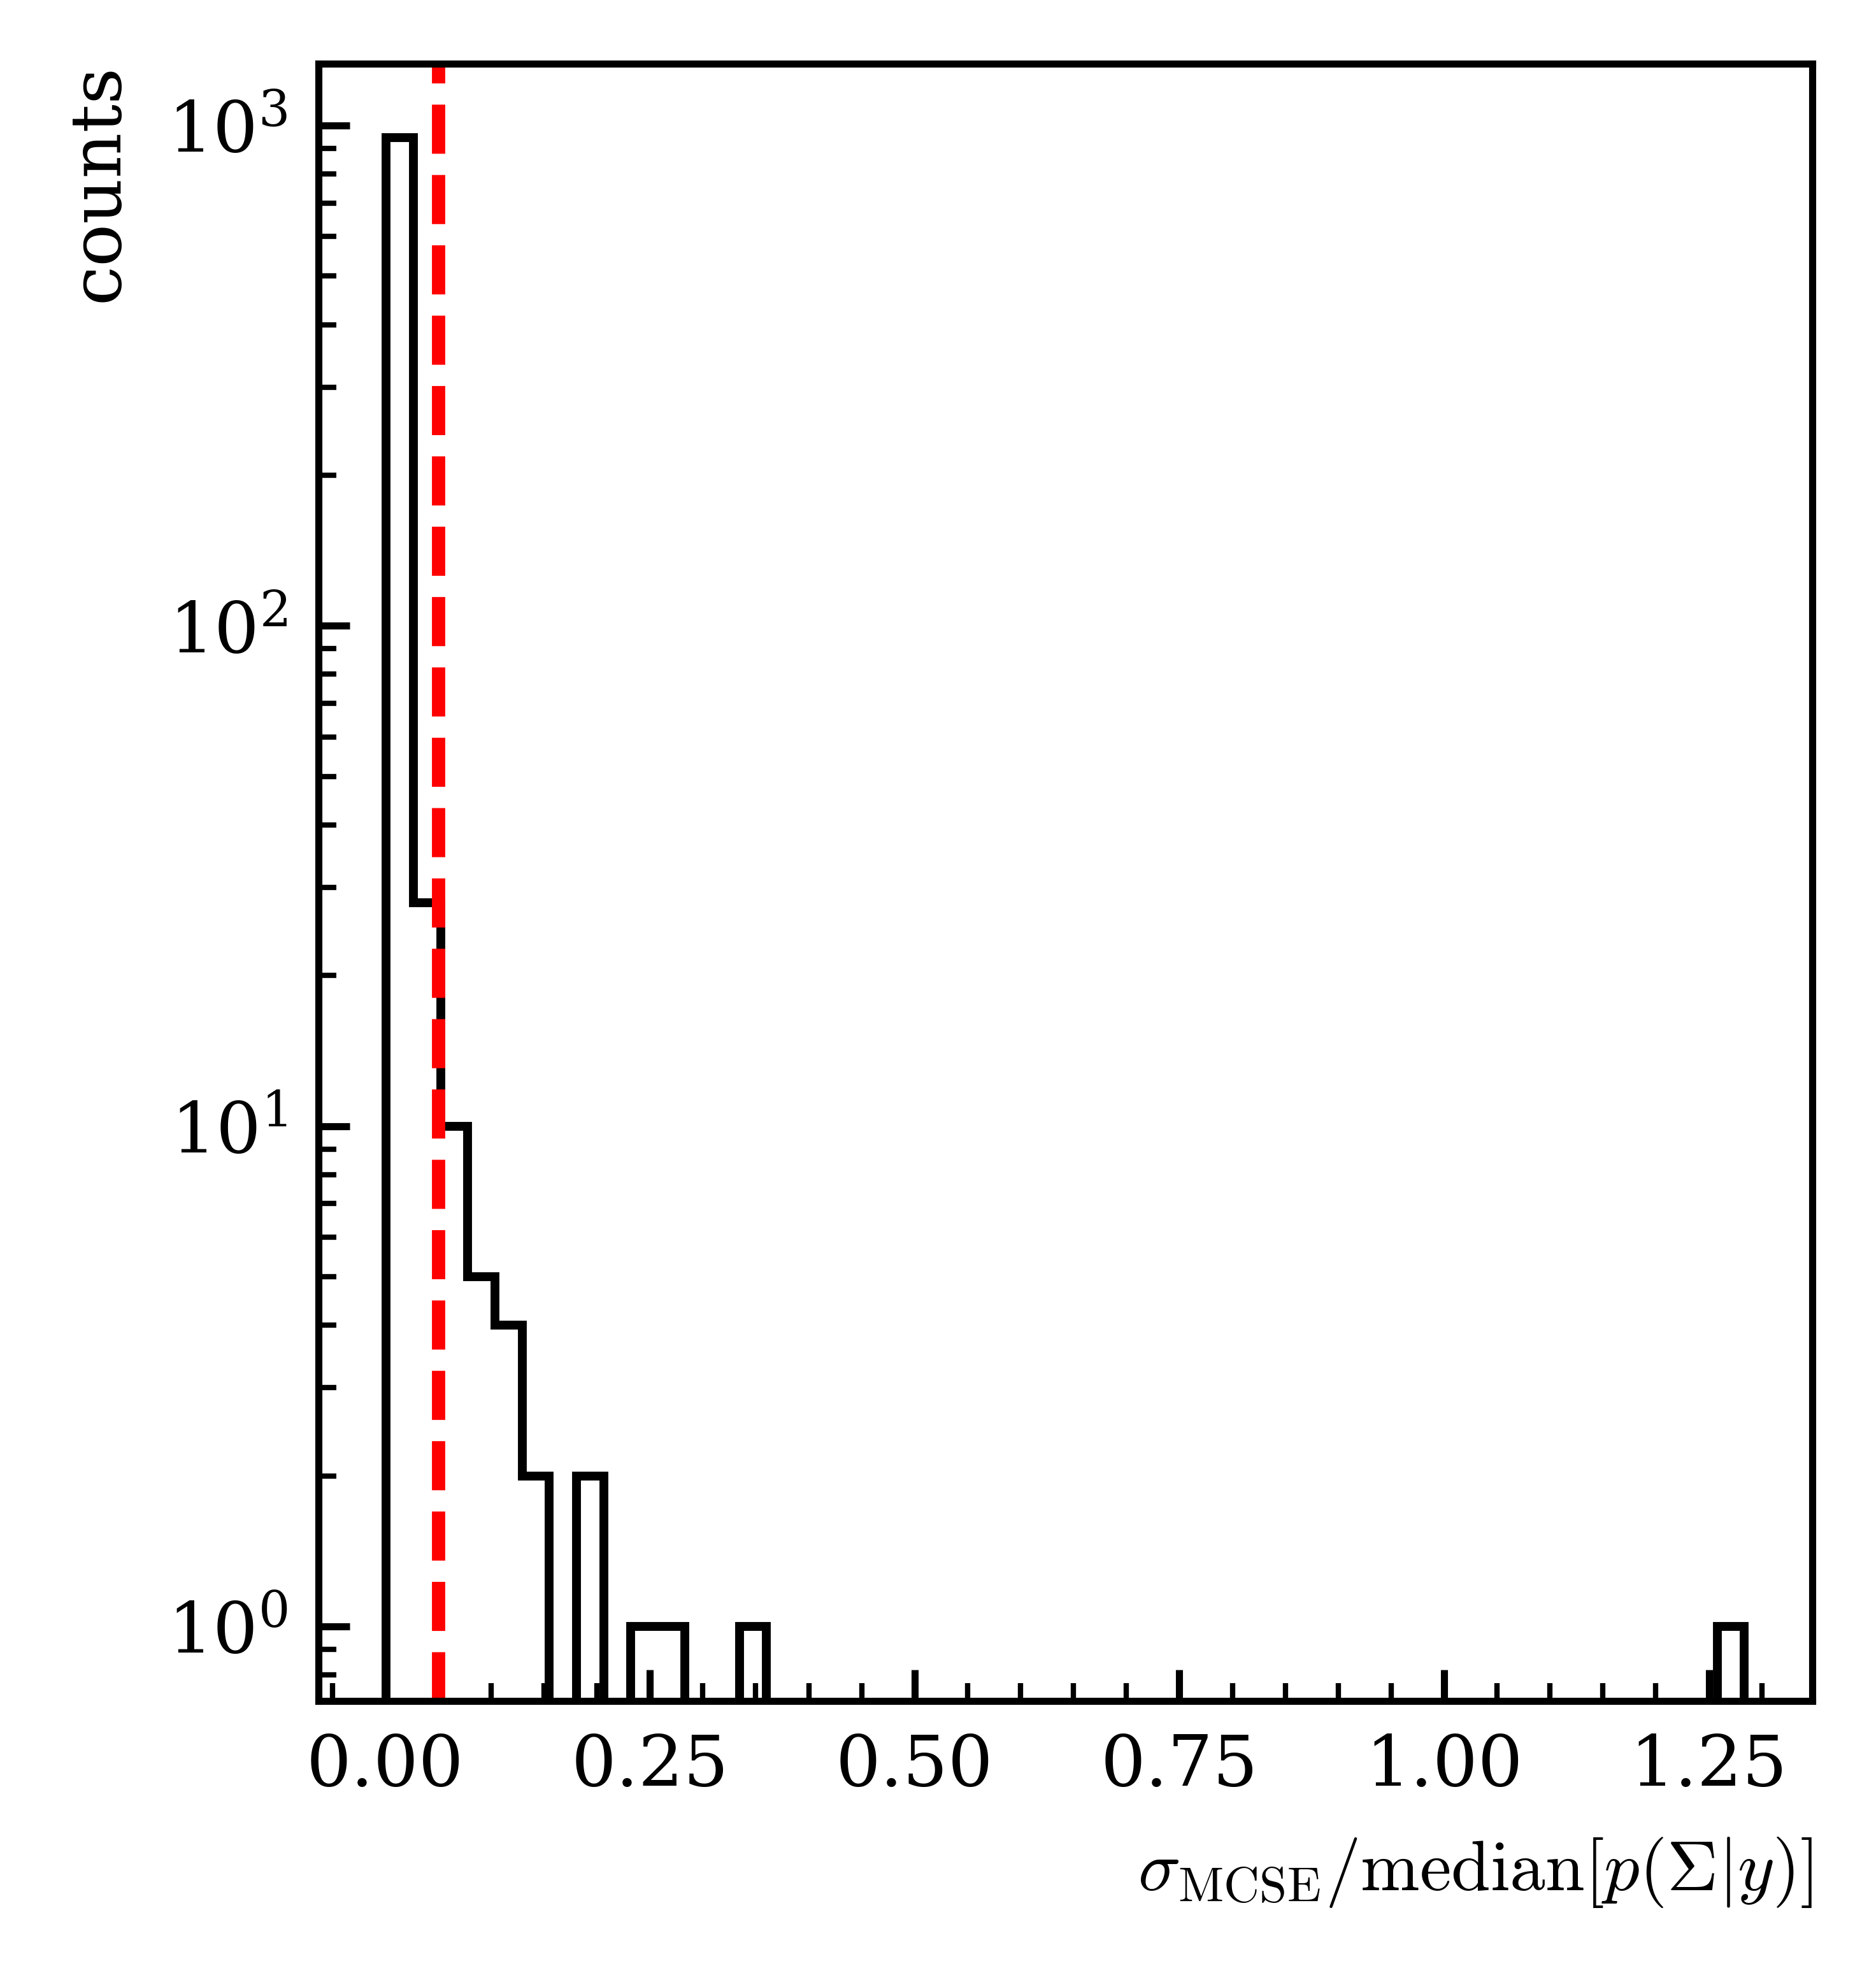

In [9]:
plt.rcParams['font.size']=8
fig, ax = plt.subplots(figsize=([15.3728/2.54/2,8.6472/2.54]),dpi=1000)

ax.hist(np.abs(np.array(diagnostics_df.loc['mcse'].values)/np.array(diagnostics_df.loc['sigma_median'].values)),histtype='step',log=True,bins=50)
#ax.set_xlim([0,1])
#plt.hist(np.abs(np.array(diagnostics_df.loc['mcse'].values)),histtype='step',bins=20)
ax.set_xlabel(r'$\sigma_\mathrm{MCSE}/\mathrm{median}[p(\Sigma|y)]$',horizontalalignment='right',x=1.0)
ax.set_ylabel('counts',horizontalalignment='right',y=1.0)
ax.axvline(x=0.05,color='red',linestyle='--')
ax.grid(False)
ax.tick_params(axis='both',which='both',direction='in')

#plt.xscale('log')
#plt.savefig('./plots/toyMC_mcse_hist_raw.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()
fig.savefig('./plots/toyMC_mcse_hist.pdf',format='pdf',dpi=1000,bbox_inches='tight')


In [3]:
rel_err=np.abs(np.array(diagnostics_df.loc['mcse'].values)/np.array(diagnostics_df.loc['sigma_median'].values))
1-len(np.where(rel_err>0.05)[0])/len(rel_err)

0.971

In [4]:
diagnostics_df.loc['sigma_median'].values[np.where(rel_err>0.05)]

array([ 0.038 , -0.0049,  0.035 , -0.022 , -0.031 , -0.0016,  0.017 ,
        0.014 , -0.0085, -0.039 ,  0.026 , -0.016 ,  0.019 , -0.0078,
       -0.029 , -0.035 , -0.012 ,  0.038 ,  0.022 , -0.033 ,  0.039 ,
        0.033 , -0.013 ,  0.021 ,  0.021 ,  0.029 ,  0.0079, -0.017 ,
       -0.033 ])

# Checking posterior distributions

In [53]:
all_sigmas=[]
for i in range(len(sigma_df.columns)):
    #all_sigmas.extend((np.array(sigma_df[f'toybin{i:04d}'].values)))
    all_sigmas.append((np.mean(sigma_df[f'toybin{i:04d}'].values)-0.5)/np.std(sigma_df[f'toybin{i:04d}'].values))

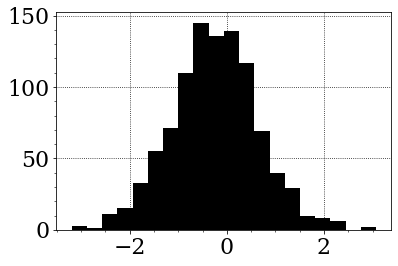

In [54]:
plt.hist(all_sigmas,bins=20)
plt.show()

In [57]:
h=r.TH1D("h","h",20,-5,5)
for i in range(len(all_sigmas)):
    h.Fill(all_sigmas[i])

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


In [58]:
c=r.TCanvas("c","c")
c.Draw("")
c.SetBottomMargin(0.15)
c.SetLeftMargin(0.15)
h.Draw("")
h.GetXaxis().SetLabelFont(133)
h.GetYaxis().SetLabelFont(133)
h.GetXaxis().SetTitleFont(133)
h.GetYaxis().SetTitleFont(133)
h.GetYaxis().SetTitle("counts")
#h.GetXaxis().SetTitle("Xi")
h.GetXaxis().SetTitle("#Sigma")
h.SetTitle("")
h.GetXaxis().SetTitleSize(50)
h.GetXaxis().SetLabelSize(50)
h.GetYaxis().SetTitleSize(50)
h.GetYaxis().SetLabelSize(50)

h.SetLineColor(1)
r.gStyle.SetOptStat(0)
h.GetXaxis().SetTitleOffset(1.5)
f=r.TF1("f","gaus",-5,5)
h.Fit(f,"SN","",-5,5)
f.Draw("Same")
t=r.TLatex()
t.SetTextAlign(22)
t.SetTextFont(133)
t.SetTextSize(50)
mu = f.GetParameter(1)
mu_err = f.GetParError(1)
sigma=f.GetParameter(2)
sigma_err=f.GetParError(2)
t.DrawLatex(0,50,f"#color[2]{{#font[132]{{#mu={mu:.4f}#pm{mu_err:.4f}, #sigma={sigma:.4f}#pm{sigma_err:.4f}}}}}")

 FCN=9.99128 FROM MIGRAD    STATUS=CONVERGED      54 CALLS          55 TOTAL
                     EDM=5.42676e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.23570e+02   8.99233e+00   1.14915e-02  -1.45375e-04
   2  Mean        -2.56412e-01   2.81380e-02   4.54693e-05   3.66505e-03
   3  Sigma        8.83375e-01   2.18083e-02   1.04012e-05  -8.82192e-02


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


In [52]:
#c.SaveAs("./plots/combined_post_add_raw.pdf")
c.SaveAs("./plots/combined_post_add_raw.root")

Info in <TCanvas::SaveAs>: ROOT file ./plots/combined_post_add_raw.root has been created


In [5]:
all_2pi0sigmas=[]
for i in range(len(sigma_2pi0_df.columns)):
    all_2pi0sigmas.extend((np.array(sigma_2pi0_df[f'toybin{i:04d}'].values)))
    #all_sigmas.extend((np.array(sigma_df[f'toybin{i:04d}'].values)-0.5)/np.std(sigma_df[f'toybin{i:04d}'].values))

In [6]:
h=r.TH1D("h","h",100,-1,1)
for i in range(len(all_2pi0sigmas)):
    h.Fill(all_2pi0sigmas[i])

In [9]:
c=r.TCanvas("c","c")
c.Draw("")
c.SetBottomMargin(0.15)
h.Draw("")
h.GetXaxis().SetLabelFont(133)
h.GetYaxis().SetLabelFont(133)
h.GetXaxis().SetLabelFont(133)
h.GetYaxis().SetLabelFont(133)
h.GetXaxis().SetLabelSize(45)
h.GetYaxis().SetLabelSize(45)
h.GetXaxis().SetTitleSize(45)
h.GetYaxis().SetTitleSize(45)
h.GetYaxis().SetTitle("counts")
#h.GetXaxis().SetTitle("#font[132]{#frac{p(#Sigma|D_{#it{i}})-#Sigma_{true}}{std(p(#Sigma|D_{#it{i}}))}}")
h.GetXaxis().SetTitle("#Sigma^{bkg}")
h.SetLineColor(1)
h.SetTitle("")
r.gStyle.SetOptStat(0)
h.GetXaxis().SetTitleOffset(1.5)
f=r.TF1("f","gaus",-2,2)
h.Fit(f,"SN","",-1,1)
f.Draw("Same")
t=r.TLatex()
t.SetTextAlign(22)
t.SetTextFont(133)
t.SetTextSize(45)
mu = f.GetParameter(1)
mu_err = f.GetParError(1)
sigma=f.GetParameter(2)
sigma_err=f.GetParError(2)
t.DrawLatex(0,5e3,f"#color[2]{{#mu={mu:.5f}#pm{mu_err:.5f}, #sigma={sigma:.5f}#pm{sigma_err:.5f}}}")

 FCN=12.2885 FROM MIGRAD    STATUS=CONVERGED      59 CALLS          60 TOTAL
                     EDM=1.30798e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.17030e+06   8.68526e+02   1.51172e+00   7.15321e-07
   2  Mean        -3.00008e-01   1.12552e-05   1.43055e-07   9.21193e-01
   3  Sigma        5.03349e-02   7.96695e-06   4.42169e-07   8.05313e+00


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


In [10]:
#c.SaveAs("./plots/combined2pi0_post_add_raw.pdf")
c.SaveAs("./plots/combined2pi0_post_add_raw.root")

Info in <TCanvas::SaveAs>: ROOT file ./plots/combined2pi0_post_add_raw.root has been created


In [4]:
fit=fit_bin(nsamples=5000,binnr=11)
samples=fit[0]
summary=fit[1]

0.9496291560102302
391 303


INFO:cmdstanpy:compiling stan file /Users/jakob/Documents/Studium/master_thesis/bayes/etap_event_based_fit/toyMC_stan.stan to exe file /Users/jakob/Documents/Studium/master_thesis/bayes/etap_event_based_fit/toyMC_stan
INFO:cmdstanpy:compiled model executable: /Users/jakob/Documents/Studium/master_thesis/bayes/etap_event_based_fit/toyMC_stan
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


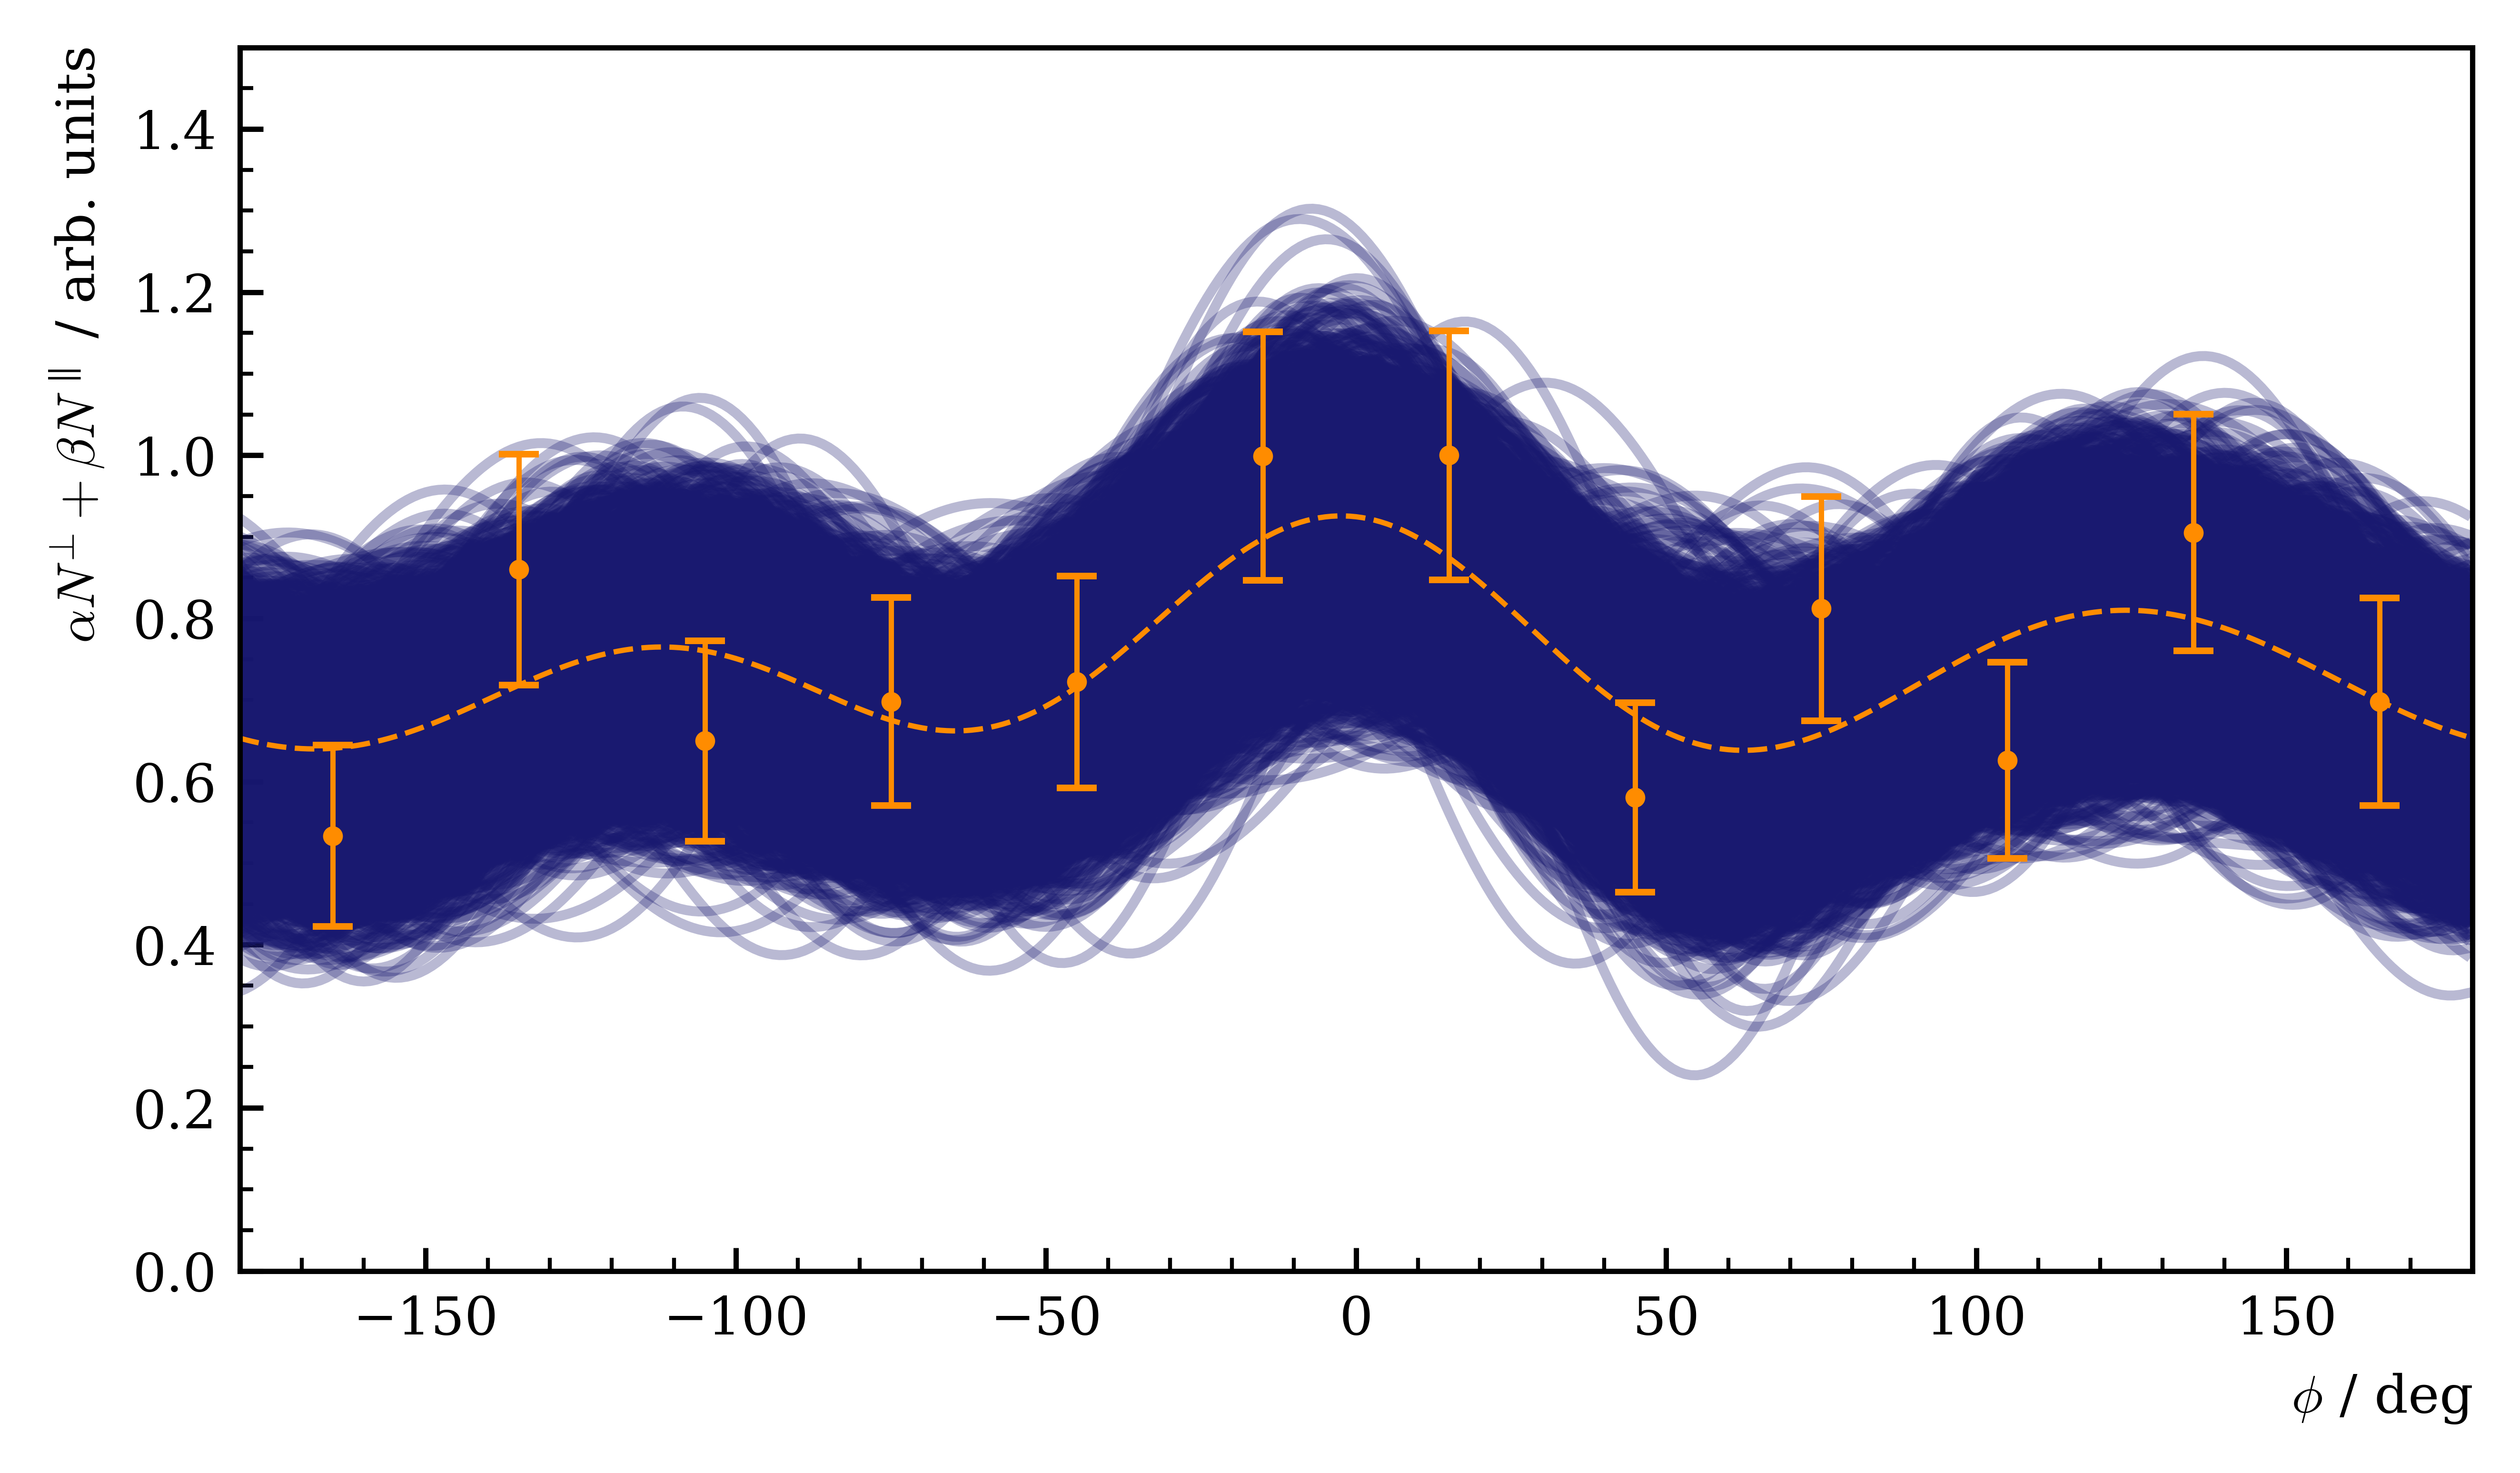

Warning in <TROOT::Append>: Replacing existing TH1: p45 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: m45 (Potential memory leak).


In [10]:
plt.rcParams['font.size']=8
plt.rcParams['axes.grid']=False
#read data
i=11 # define which bin to use
df=pd.read_csv(f"toybins/toybin{i:04d}.txt",sep="\t")
df.columns=['pol','phi','weight']
#select only prmpt events
p45=df.loc[(df['weight']==1)&(df['pol']>0)].reset_index(drop=True)
m45=df.loc[(df['weight']==1)&(df['pol']<0)].reset_index(drop=True)
hp45=r.TH1F("p45","p45",12,-180,180)
hm45=r.TH1F("m45","m45",12,-180,180)
#histogram them
for i in p45['phi'].values:
    hp45.Fill(i)
for i in m45['phi'].values:
    hm45.Fill(i)
#normalize    
norm_p = 1./hp45.Integral()
norm_m = 1./hm45.Integral()
hp45.Scale(norm_p)
hm45.Scale(norm_m)

#build polarization weighted sum
pol_p45=np.abs(np.mean(p45['pol']))
pol_m45=np.abs(np.mean(m45['pol']))
hp45.Add(hp45,hm45,pol_m45/(pol_p45+pol_m45),pol_p45/(pol_m45+pol_p45))
hp45.Scale(1./hp45.GetMaximum())


#write values of histo to numpy array
asym=[]
asym_err=[]
phi=[]
for i in range(hp45.GetNbinsX()):
    asym.append(hp45.GetBinContent(i+1))
    asym_err.append(hp45.GetBinError(i+1))
    phi.append(hp45.GetBinCenter(i+1))
asym=np.array(asym)
asym_err=np.array(asym_err)
phi=np.array(phi)
xx=np.arange(-180,180)

#plot results
fig, ax = plt.subplots(figsize=[15.3728/2.54,8.6472/2.54],dpi=1000)
ax.errorbar(x=phi,y=asym,yerr=asym_err,fmt='.',elinewidth=0.8,markersize=4,color='darkorange',zorder=3,label='data')
#get ALL values of fourier coeff
eff_list=[]
for i in range(4000):
    #get mean values of fourier coeff
    tmp_a=[samples[f'a[{j+1}]'][i] for j in range(4)]
    tmp_b=[samples[f'b[{j+1}]'][i] for j in range(4)]
    #put them in efficiency function
    def tmp_eff(x,c):
        val=1 # a0=0,b0=1
        for i in range(4):
            val+=tmp_a[i]*np.sin((i+1)*x*np.pi/180)+tmp_b[i]*np.cos((i+1)*x*np.pi/180)
        return c*val 
    popt,pcov = curve_fit(tmp_eff,xdata=phi,ydata=asym,p0=1,sigma=asym_err)
    eff_list.append(tmp_eff(xx,popt))
    #ax.plot(xx,eff(xx,popt),color='midnightblue',alpha=0.5)
for i in range(4000):
    if(i==0):
        ax.plot(xx,eff_list[i],color='midnightblue',alpha=0.3,label='PPC')
    else:
        ax.plot(xx,eff_list[i],color='midnightblue',alpha=0.3)
#get mean values of fourier coeff
a=[summary['Mean'][f'a[{i+1}]'] for i in range(4)]
b=[summary['Mean'][f'b[{i+1}]'] for i in range(4)]
#put them in efficiency function
def eff(x,c):
    val=1 # a0=0,b0=1
    for i in range(4):
        val+=a[i]*np.sin((i+1)*x*np.pi/180)+b[i]*np.cos((i+1)*x*np.pi/180)
    return c*val 
popt,pcov = curve_fit(eff,xdata=phi,ydata=asym,p0=1,sigma=asym_err)
ax.plot(xx,eff(xx,popt),color='darkorange',ls='--',linewidth=0.8,label='Mean of PPC')
ax.tick_params(axis='both',which='both',direction='in')

    
    

ax.set_ylim([0,1.5])
ax.set_xlim([-180,180])
ax.set_xlabel("$\phi$ / deg",horizontalalignment='right',x=1.0)
ax.set_ylabel(r"$\alpha N^{\bot} + \beta N^{\parallel} $ / arb. units",horizontalalignment='right',y=1.0)
ax.grid(False)
#plt.legend()
plt.show()

In [11]:
fig.savefig('./plots/toyMC_eff_PPC.png',format='png',dpi=1000,bbox_inches='tight')